<a href="https://www.kaggle.com/code/kelixirr/probability-calibration-tutorial?scriptVersionId=158757250" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Probability Calibration In Machine Learning by Neuraldemy (Amritesh Kumar)

**Tutorial By: Neuraldemy** https://neuraldemy.com/

In this tutorial, we are going to learn the concepts related to probability calibration in machine learning. Probability calibration is used in many binary classification problems to ensure that the probability predicted by machine learning models can be re-calibrated in a manner so that we can be confident about the decision. In other words, to find the true likehood.  

For instance, consider a binary classification problem where the model predicts whether an email is spam or not. The model might output a predicted probability of 0.8 for an email, indicating an 80% chance that it is spam. This is called its predicted probability. 

But in reality, things may vary, let say 70% of emails are spam and 30% are not, then the true likelihood of an email being spam is 0.7, not 0.8 as predicted by the model.

Calibration is the process of aligning the predicted probabilities with the true likelihood. In an ideally calibrated model, a predicted probability of 0.8 should mean that, on average, 80% of instances with a predicted probability of 0.8 actually belong to that particular class. Calibration ensures that the predicted probabilities accurately reflect the underlying distribution of the data. 

**Why is calibration important?** 

Calibrating the predicted probabilities of your trained model can be important in cases where you have to take critical decisions such as giving loan etc. You want to make sure that you are not just approximating. 

There are various methods through which you can do probability calibration and not all models require calibration. 

### How do we calibrate predicted probabilities? 

There are various methods to calibrate. Here is what goes behind the scene. 

1. **Collecting Probabilities**: During model training, the algorithm produces probability estimates for each instance. These probabilities represent the model's confidence in its predictions.
2. **Dividing into Bins**: The predicted probabilities are often divided into bins or intervals.
3. **Calculating Observed Frequencies**: The true likelihood or observed frequencies of the events are calculated within each bin. This involves looking at the actual outcomes for instances falling into each probability bin.
4. **Adjusting Predicted Probabilities**: The predicted probabilities are adjusted or scaled based on the difference between the observed and predicted frequencies. The goal is to bring the predicted probabilities in line with the true likelihood.
5. **Calibration Methods**: Various calibration methods, such as Platt scaling, isotonic regression, or Beta calibration, may be employed. These methods use different mathematical approaches to perform the adjustments.
6. **Evaluating Calibration**: The effectiveness of calibration is often assessed using calibration metrics like Expected Calibration Error (ECE) or Brier Score. These metrics quantify the difference between predicted and observed probabilities.



Sklearn offers a class that allows you to do the calibration in one line but here are some steps you can follow in practice if you want to calibrate using your own custom methods. Just note that instead of creating a separate datset for calibration, you can also use cross-validation: 

1. Take a binary Classifier (works for binary classification but can be extend to multi class)
2. Divied the dataset into 3 sets - Train, Cal, Test
3. Train a classifier on train set
4. Make prediction on cal set
5. Make predict on set test
5. Use cal set prediction probability to train our calibration object (Platt Scaling etc.)
6. Use the learned calibration to scale our test prediction from previous classifier
7. Make a plot between y_test and y_test_calibrated values

### Platt Scaling:

It is a method used to transform the output of a binary classifier (e.g., a support vector machine) into a probability estimate. The goal is to map the raw decision values produced by the classifier into a calibrated probability scale that can be interpreted as the likelihood of a data point belonging to the positive class. Platt scaling involves fitting a logistic sigmoid function to the raw decision values produced by a binary classifier. The sigmoid function is given by:

$ 
P(y=1|x) = \frac{1}{1 + e^{Af(x) + B}} $

where \( A \) and \( B \) are parameters to be learned.

The goal is to minimize the log-likelihood loss function:

$
L(A, B) = -\sum_{i=1}^{N} [y_i \log(P(y=1|x_i)) + (1-y_i) \log(1 - P(y=1|x_i))]
$

since we have only two parameters, it does not need many data points. This means platt scaling works best if you have less number of data points. If you have more data points use isotonic regression.

## Manual Approach - Platt Scaling

In [40]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

X, y = cancer.data, cancer.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_cal, X_test, y_cal, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

We first have to divide our datasets into three part. Training, Callibration (Dev or Val set)  And a Test Set

In [41]:
print(X_train.shape)
print(X_cal.shape)
print(X_test.shape)

(398, 30)
(85, 30)
(86, 30)


In [43]:
# Train the model on a classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 200, random_state = 42, n_jobs = -1 )
rf.fit(X_train, y_train)
rf_predict = rf.predict_proba(X_cal)[:, 1] # keep the second column 
rf_predict

array([0.22 , 0.905, 0.   , 0.12 , 0.005, 0.995, 1.   , 0.97 , 0.995,
       0.28 , 0.   , 0.01 , 0.9  , 0.015, 1.   , 1.   , 0.   , 0.13 ,
       0.005, 1.   , 0.985, 0.825, 0.   , 0.01 , 0.995, 0.97 , 0.97 ,
       1.   , 0.045, 0.605, 1.   , 0.94 , 0.07 , 1.   , 0.125, 0.685,
       0.025, 0.8  , 0.   , 0.99 , 0.95 , 0.975, 0.245, 0.155, 1.   ,
       0.   , 0.015, 0.995, 1.   , 0.025, 0.78 , 1.   , 0.   , 0.94 ,
       0.995, 0.   , 0.02 , 0.99 , 0.235, 0.985, 0.985, 1.   , 0.   ,
       0.995, 0.   , 0.95 , 0.975, 0.   , 0.79 , 0.99 , 0.095, 1.   ,
       0.   , 0.005, 0.99 , 0.02 , 0.985, 1.   , 0.715, 0.785, 0.005,
       0.975, 0.98 , 0.8  , 0.04 ])

Once we have the predicted probabilities, we will calibrate it using Platt scaling which is logistic regression. It is trained on predict prob of rf model. 

In [44]:
from sklearn.linear_model import LogisticRegression
platt_scaling = LogisticRegression()
platt_scaling.fit(rf_predict.reshape(-1, 1), y_cal)

LogisticRegression()

In [45]:
rf_test_prob = rf.predict_proba(X_test)[:, 1]
rf_test_prob

array([1.   , 0.995, 1.   , 0.055, 0.98 , 1.   , 0.065, 0.985, 0.845,
       0.56 , 0.99 , 1.   , 0.   , 0.015, 0.975, 0.005, 0.98 , 0.98 ,
       1.   , 0.995, 1.   , 0.85 , 0.   , 0.945, 0.05 , 1.   , 0.885,
       0.69 , 0.985, 0.005, 1.   , 0.995, 0.88 , 0.945, 0.92 , 0.105,
       0.905, 1.   , 0.02 , 0.995, 0.715, 0.96 , 0.675, 0.995, 0.995,
       0.   , 1.   , 1.   , 0.   , 0.355, 0.655, 0.   , 0.96 , 0.84 ,
       1.   , 0.03 , 1.   , 0.   , 0.005, 0.95 , 0.015, 0.475, 0.   ,
       0.04 , 1.   , 0.78 , 0.005, 0.96 , 0.   , 0.98 , 0.55 , 0.98 ,
       0.97 , 0.995, 0.68 , 1.   , 0.695, 0.995, 1.   , 1.   , 0.975,
       0.935, 0.995, 0.01 , 1.   , 0.865])

In [46]:
test_cal_prob = platt_scaling.predict_proba(rf_test_prob.reshape(-1, 1))[:, 1]
test_cal_prob

array([0.90073269, 0.89884002, 0.90073269, 0.14656411, 0.89296872,
       0.90073269, 0.15189351, 0.89495841, 0.82558973, 0.58861202,
       0.89691538, 0.90073269, 0.11997122, 0.12678033, 0.89094593,
       0.12220509, 0.89296872, 0.89296872, 0.90073269, 0.89884002,
       0.90073269, 0.82859155, 0.11997122, 0.87809332, 0.14395799,
       0.90073269, 0.84846489, 0.71176729, 0.89495841, 0.12220509,
       0.90073269, 0.89884002, 0.84574631, 0.87809332, 0.86640558,
       0.17481162, 0.85894721, 0.90073269, 0.12912238, 0.89884002,
       0.73281172, 0.88467524, 0.69867819, 0.89884002, 0.89884002,
       0.11997122, 0.90073269, 0.90073269, 0.11997122, 0.37698176,
       0.68071281, 0.11997122, 0.88467524, 0.8225466 , 0.90073269,
       0.13391708, 0.90073269, 0.11997122, 0.12220509, 0.88032248,
       0.12678033, 0.5003481 , 0.11997122, 0.13886143, 0.90073269,
       0.78275796, 0.12220509, 0.88467524, 0.11997122, 0.89296872,
       0.57840996, 0.89296872, 0.88888967, 0.89884002, 0.70307

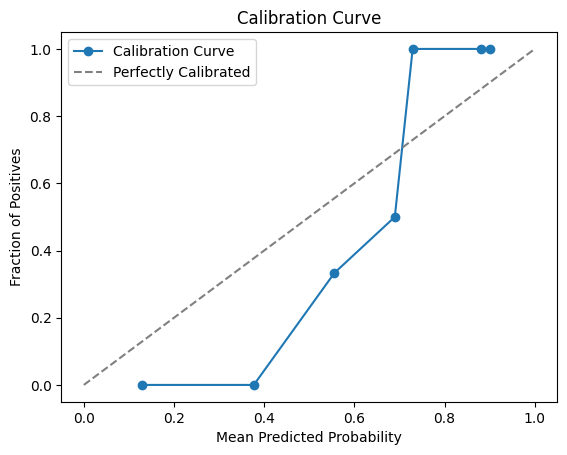

In [47]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, test_cal_prob, n_bins = 10, strategy = "uniform")

plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

The perfectly calibrated model will be close to the line y = x in the graph.

## CV approach Sklearn - Platt Scaling

We will use method as sigmoid which is platt scaling and estimator as rf which is our base classifier that we already have. Since our classifier is already trained, we will not be training it again so we will enter prefit in cv. If you have not trained your base classifier you can use some value in cv and then train it using calibratedclassifiercv. 

In [48]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(estimator = rf, method = "sigmoid", cv = "prefit")
calibrated_clf.fit(X_cal, y_cal)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(n_estimators=200,
                                                        n_jobs=-1,
                                                        random_state=42))

In [49]:
calibrated_clf.predict_proba(X_test)

array([[0.0258807 , 0.9741193 ],
       [0.02682026, 0.97317974],
       [0.0258807 , 0.9741193 ],
       [0.96422503, 0.03577497],
       [0.02984216, 0.97015784],
       [0.0258807 , 0.9741193 ],
       [0.96161053, 0.03838947],
       [0.02879987, 0.97120013],
       [0.07637411, 0.92362589],
       [0.40010151, 0.59989849],
       [0.02779295, 0.97220705],
       [0.0258807 , 0.9741193 ],
       [0.97580107, 0.02419893],
       [0.97306634, 0.02693366],
       [0.03092097, 0.96907903],
       [0.974921  , 0.025079  ],
       [0.02984216, 0.97015784],
       [0.02984216, 0.97015784],
       [0.0258807 , 0.9741193 ],
       [0.02682026, 0.97317974],
       [0.0258807 , 0.9741193 ],
       [0.0738303 , 0.9261697 ],
       [0.97580107, 0.02419893],
       [0.03822973, 0.96177027],
       [0.96546715, 0.03453285],
       [0.0258807 , 0.9741193 ],
       [0.05810386, 0.94189614],
       [0.20468103, 0.79531897],
       [0.02879987, 0.97120013],
       [0.974921  , 0.025079  ],
       [0.

We will draw calibration curve or reliability diagram using sklearn recommended method. One more thing you should note here, you don't need to perfom probability calibration step if you are using CalibrationDisplay.from_estimator directly to draw the reliability diagram but in the previous case when we used calibration_curve, you need to calculate the calibration step. 

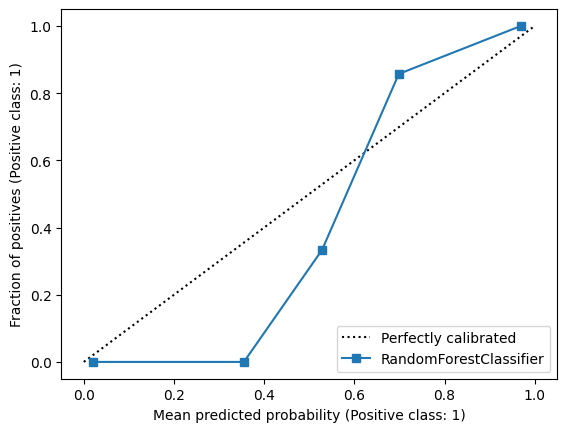

In [50]:
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_estimator(rf, X_test, y_test)
plt.show()

## Isotonic Regression

If you have more than 1000 samples use isotonic regression for probability calibration. 

Isotonic regression is like drawing a line on a graph that goes up or stays the same without going down. Imagine you have a bunch of points on a graph (like dots), and you want to draw a line that follows the general trend of going up or staying flat. Isotonic regression helps you do that. The goal is to find a line that gets as close as possible to all the points, but the line can only go up or stay flat as you move from left to right. It's like predicting the probability of something (let's say, the chance of rain). Isotonic regression helps adjust predictions to make them more reliable – like saying, "If I predict a 70% chance of rain, it should really feel like a 70% chance based on past predictions." The rule is simple – the line can't go down. It can go up or stay flat, but it can't drop. It's all about keeping things moving in a positive or constant direction. 

It is a technique used for fitting a piecewise-constant non-decreasing function to a set of observations. The primary aim of isotonic regression is to find a monotonic relationship between a predictor variable and a response variable, preserving the order of observations. This is particularly useful when dealing with data that exhibits a non-linear relationship or lacks a clear functional form.  It can be used to post-process the output of a binary classifier, ensuring that predicted probabilities are well-calibrated and reflect the true likelihood of a positive outcome. 

### Isotonic Regression Derivation:

The objective is to find a vector $ (y) $ that minimizes the sum of squared differences between the observed values $ (y_i) $ and the fitted values $ (m_i) $ subject to the constraint that $ (m_i \leq m_{i+1}) $ for all i.

Mathematically, this is formulated as:

$ \text{minimize} \sum_{i=1}^{n} (y_i - m_i)^2 $

subject to

$  m_i \leq m_{i+1} \text{ for all } i $

This problem is commonly solved using algorithms like pool-adjacent-violators algorithm (PAVA) or other optimization methods.


## Important Note

Before we perform calibration we should also check for the brier score and ROC-AUC because they provide insights into the effectiveness of the calibration process. These metrics are commonly used in probability calibration assessment, and comparing their values before and after calibration helps assess the improvement in the reliability of predicted probabilities. 

Brier Score measures the mean squared difference between predicted probabilities and actual outcomes. Lower Brier Score indicates better calibration, with a perfect score of 0. A higher score suggests that predicted probabilities are not well-calibrated.

This time we will choose isotonic regression in method. 

In [61]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss, roc_auc_score
import matplotlib.pyplot as plt

# Generate a synthetic dataset
X, y = make_classification(n_samples=1500, n_features=20, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Calibrate the classifier using isotonic regression
calibrated_classifier = CalibratedClassifierCV(clf, method='isotonic', cv='prefit')
calibrated_classifier.fit(X_test, y_test)

# Predict probabilities on the test set
probabilities_before_calibration = clf.predict_proba(X_test)[:, 1]
probabilities_after_calibration = calibrated_classifier.predict_proba(X_test)[:, 1]

# Evaluate Brier Score and ROC-AUC before and after calibration
brier_before = brier_score_loss(y_test, probabilities_before_calibration)
brier_after = brier_score_loss(y_test, probabilities_after_calibration)
roc_auc_before = roc_auc_score(y_test, probabilities_before_calibration)
roc_auc_after = roc_auc_score(y_test, probabilities_after_calibration)

print(f"Brier Score (Before Calibration): {brier_before:.4f}")
print(f"Brier Score (After Calibration): {brier_after:.4f}")
print(f"ROC-AUC (Before Calibration): {roc_auc_before:.4f}")
print(f"ROC-AUC (After Calibration): {roc_auc_after:.4f}")

Brier Score (Before Calibration): 0.0592
Brier Score (After Calibration): 0.0469
ROC-AUC (Before Calibration): 0.9658
ROC-AUC (After Calibration): 0.9712


As you can see the brier score has improved. If you try it using sigmoid it won't improve the brier score much. Let's display it

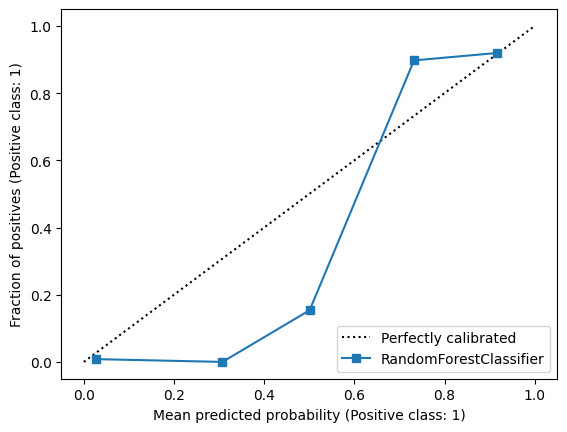

In [60]:
disp = CalibrationDisplay.from_estimator(clf, X_test, y_test, n_bins = 5)
plt.show()

### Understanding the Axes:

X-axis (Mean Predicted Probability):

Represents the average predicted probability for a group of instances. It ranges from 0 to 1.
Y-axis (Observed Accuracy):

Indicates the actual accuracy observed for instances in each group, often represented as a fraction or percentage.

### Key Elements:

Perfectly Calibrated Line: A diagonal line at y=x represents a perfectly calibrated classifier. Points lying on this line indicate perfect alignment between predicted probabilities and observed outcomes.

Calibration Curve: The actual calibration curve is a plot of mean predicted probability (on the x-axis) against observed accuracy (on the y-axis). It shows how well the predicted probabilities align with the true outcomes.

### Reading the Curve:

Ideal Calibration: If the curve closely follows the diagonal line, it suggests excellent calibration. The closer the curve is to the diagonal, the better the predicted probabilities reflect the true probabilities.

Under-Confidence or Over-Confidence: If the curve is below the diagonal in certain regions, the model is under-confident (predicted probabilities are lower than the actual probabilities). If it's above the diagonal, the model is over-confident (predicted probabilities are higher than the actual probabilities).

### Interpreting Specific Points:

Points on the Curve: Each point on the curve represents a group of instances with similar predicted probabilities. Points away from the diagonal indicate areas where the model's predictions need adjustment.

Outliers: Outliers or significant deviations from the diagonal suggest potential issues with calibration in certain probability ranges.

Don't get confused with bins where model is making turns. You can increase the number of bins by including n_pins into it. 

## Conclusion:

Though, sklearn provides only two calibration method at the moment, there are other methods too and not all models require probability calibration. You should use this only if your task required according the situation and problem. I highly recommend reading these resources for further understanding on probability calibration in ML.

### Sources And Further Reading: 

1. https://scikit-learn.org/stable/modules/calibration.html
2. https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf
3. https://research-information.bris.ac.uk/ws/portalfiles/portal/154625753/Full_text_PDF_final_published_version_.pdf
4. https://davidrosenberg.github.io/ttml2021/calibration/2.calibration.pdf
5. https://github.com/numeristical/resources/blob/master/CalibrationWorkshop/Calibration_Workshop_1.ipynb

This tutorial is part of Neuraldemy tutorials on machine learning. If it was helpful, consider joining us on https://neuraldemy.com/ and do upvote the notebook if you are reading this on kaggle.